# Extra figures for chapter data

## A DEM of the Zwalm catchment

In [134]:
import openeo
import geopandas as gpd
import pandas as pd
import shapely
from pathlib import Path
import numpy as np
import pickle
import xarray as xr
import rioxarray
import hvplot
import hvplot.xarray
import hvplot.dask
import os
import matplotlib.pyplot as plt
from matplotlib import colors
connection = openeo.connect("openeo.vito.be").authenticate_oidc()
pad = Path(os.getcwd())
if pad.name != "Python":
    pad_correct = Path("../../Python")
    os.chdir(pad_correct)
from functions.plotting_functions import plot_discrete_raster
exec_download = True
write_fig = True

%load_ext autoreload
%autoreload 2

Authenticated using refresh token.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#connection.list_collections()
connection.describe_collection('COPERNICUS_30')

{'assets': {'metadata_iso_19139': {'href': 'https://services.terrascope.be/collectioncatalogue/srv/api/records/urn:eop:VITO:COP_DEM_GLO_30M_COG/formatters/xml?approved=true',
   'roles': ['metadata', 'iso-19139'],
   'title': 'ISO 19139 metadata',
   'type': 'application/vnd.iso.19139+xml'},
  'thumbnail': {'href': 'https://services.terrascope.be/collectioncatalogue/images/quicklooks/COP_DEM_GLO_30M_COG_QL.png',
   'roles': ['thumbnail'],
   'title': 'Thumbnail',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands', 'values': ['DEM']},
  't': {'extent': ['2010-12-12T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'step': 0.0002777777777777778,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-90, 90],
   'step': 0.0002777777777777778,
   'type': 'spatial'}},
 'description': 'Copernicus Global 30 meter Digital Elevation Model dataset in COG format.',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2010-12-12T00:00:00Z', None]]}},
 'id': 'COPERNICUS_30',
 'keywords': ['VITO',
  'TERRASCOPE',
  'COPERNICUS',
  'ESA',
  'Radar',
  'TDX',
  'TSX',
  'Elevation',
  'DSM',
  'DEM'],
 'license': 'proprietary',
 'links': [{'href': 'https://spacedata.copernicus.eu/documents/20126/0/CSCDA_ESA_Mission-specific+Annex.pdf',
   'rel': 'license'},
  {'href': 'https://services.terrascope.be/wmts/v2',
   'rel': 'wmts',
   'wmts:layer': 'COP_DEM_GLO_30M_COG'}],
 'providers': [{'name': 'VITO, on behalf of the Belgian Science Policy Office (BELSPO).',
   'roles': ['producer', 'licensor'],
   'url': 'https://terrascope.be'}],
 'stac_extensions': ['datacube',
  'https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
 'stac_version': '0.9.0',
 'summaries': {'eo:bands': [{'name': 'DEM'}],
  'instruments': ['TDX-1', 'TSX-1'],
  'platform': ['TSX', 'TDX']},
 'title': 'Copernicus Global 30 meter Digital Elevation Model dataset.'}

More info found here: https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.032021.4326.1

In [3]:
collection = 'COPERNICUS_30'
shape_zwalm = gpd.read_file('data/Zwalm_shape/zwalm_shapefile_emma.shp')
extent = shape_zwalm.total_bounds
print(extent)

[ 3.66751526 50.76325563  3.83821038 50.90341411]


In [4]:
spatial_extent = {'west':extent[0],'east':extent[2],'south':extent[1],'north':extent[3]}
DEM = connection.load_collection(
    collection_id= collection,
    spatial_extent= spatial_extent
)
DEM = DEM.mask_polygon(shape_zwalm['geometry'].values[0])
if not os.path.exists('data/Zwalm_DEM'):
    os.makedirs('data/Zwalm_DEM')
if exec_download:
    DEM.download('data/Zwalm_DEM/DEM_Copernicus_30.nc',format = 'NetCDF')

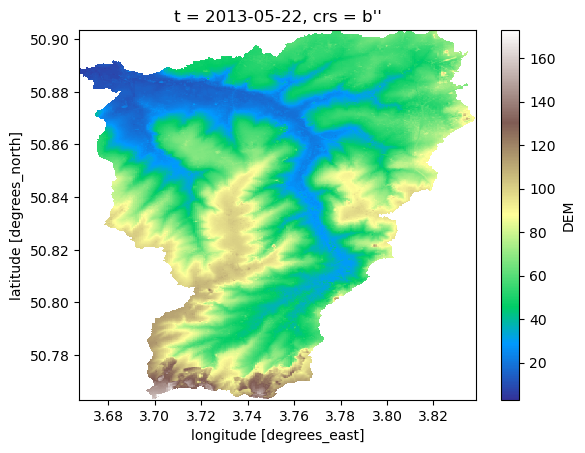

In [5]:
dem = xr.open_dataset('data/Zwalm_DEM/DEM_Copernicus_30.nc', decode_coords='all')
dem['DEM'].plot(cmap = 'terrain')

Text(0, 0.5, 'y [m]')

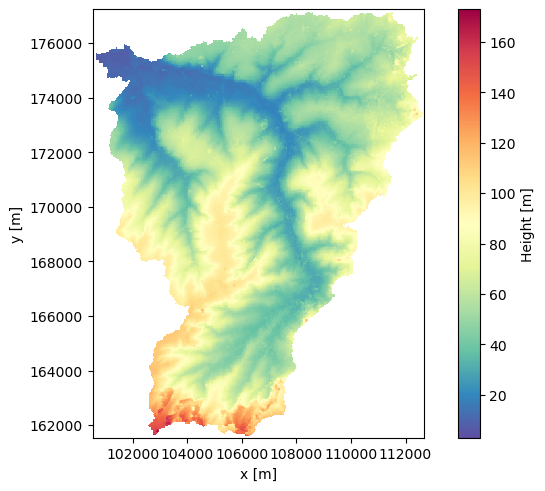

In [6]:
dem_31370 = dem.rio.reproject(dst_crs='EPSG:31370')
fig, ax = plt.subplots(constrained_layout = True)
dem_31370['DEM'].plot(ax = ax, cmap = 'Spectral_r', cbar_kwargs = {'label':'Height [m]'})
ax.set_title('')
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

## Include river

In [7]:
shape_zwalm_31370 = gpd.read_file('data/Zwalm_shape/zwalm_shapefile_emma_31370.shp')
VHA = gpd.read_file('data/VHA_waterlopen_20210204_GewVLA_Shapefile/Shapefile/Vhag.shp')

In [8]:
VHA_zwalm= VHA[VHA['NAAM'] == 'Zwalmbeek']
VHA_zwalm

,OIDN,UIDN,VHAG,NAAM,NAMEN,LENGTE,geometry
1446,3708,3708,5001,Zwalmbeek,Zwalmbeek,348.61,"LINESTRING (104155.250 174948.953, 104147.271 ..."
21102,5084,39578,5779,Zwalmbeek,Zwalmbeek,1353.75,"LINESTRING (101513.086 175367.418, 101514.771 ..."
21610,17215,40193,17516,Zwalmbeek,Zwalmbeek,135.78,"LINESTRING (105901.209 174494.337, 105899.842 ..."
26398,3707,45714,5000,Zwalmbeek,Zwalmbeek - Dorenbosbeek,22474.02,"LINESTRING (105430.433 162448.406, 105433.026 ..."


In [9]:
VHA = VHA.set_crs(epsg=31370, allow_override=True)
VHA.crs

<Derived Projected CRS: EPSG:31370>
Name: BD72 / Belgian Lambert 72
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Belgium - onshore.
- bounds: (2.5, 49.5, 6.4, 51.51)
Coordinate Operation:
- name: Belgian Lambert 72
- method: Lambert Conic Conformal (2SP)
Datum: Reseau National Belge 1972
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [10]:
shape_zwalm_31370.crs

<Derived Projected CRS: EPSG:31370>
Name: BD72 / Belgian Lambert 72
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Belgium - onshore.
- bounds: (2.5, 49.5, 6.4, 51.51)
Coordinate Operation:
- name: Belgian Lambert 72
- method: Lambert Conic Conformal (2SP)
Datum: Reseau National Belge 1972
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

<AxesSubplot:>

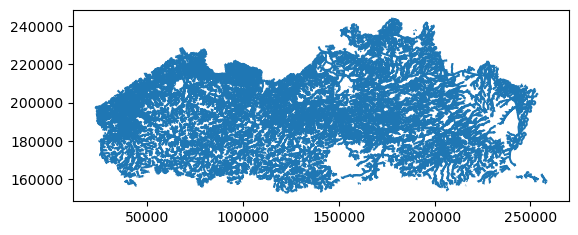

In [11]:
VHA.plot()

In [12]:
shape_zwalm_31370['geometry']

0    POLYGON ((107820.000 164940.000, 107830.000 16...
Name: geometry, dtype: geometry

In [13]:
VHA_zwalm_all = VHA[VHA['geometry'].within(shape_zwalm_31370['geometry'].values[0])]
#important to supply a raw geometry

In [14]:
VHA_zwalm = pd.concat([VHA_zwalm, VHA_zwalm_all])

<AxesSubplot:>

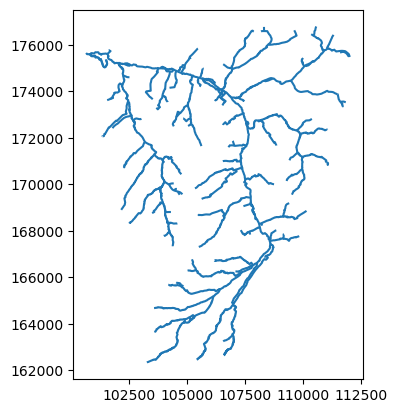

In [15]:
VHA_zwalm.plot()

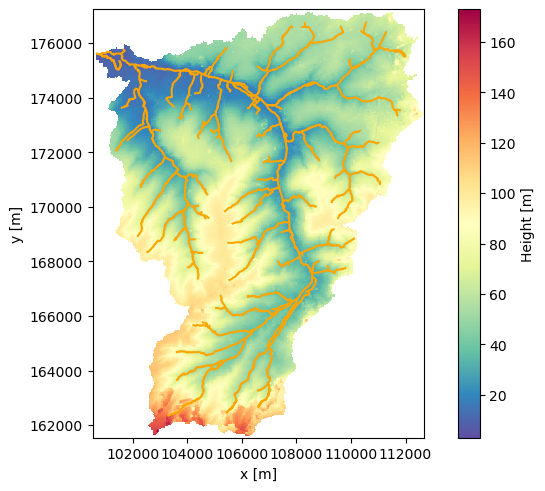

In [16]:
fig, ax = plt.subplots(constrained_layout = True)
dem_31370['DEM'].plot(ax = ax, cmap = 'Spectral_r', cbar_kwargs = {'label':'Height [m]'})
VHA_zwalm.plot(ax = ax, color = 'orange')
ax.set_title('')
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
if not os.path.exists('Figures/Figures_chapter_data'):
    os.makedirs('Figures/Figures_chapter_data')
if write_fig:
    fig.savefig('Figures/Figures_chapter_data/DEM_zwalm.png', format = 'png')
    fig.savefig('Figures/Figures_chapter_data/DEM_zwalm.pdf', format = 'pdf')

## Landuse data

In [47]:
landuse = rioxarray.open_rasterio('data/Zwalm_bodembedekking/wetransfer_landgebruik_2022-11-07_0921/'+
    'Landuse_Vlaanderen_Wallonie_final.sdat')
landuse = landuse.chunk('auto')#type:ignore
landuse_nonan = landuse.where(landuse != 255)

In [48]:
landuse_nonan

<xarray.DataArray (band: 1, y: 17495, x: 23700)>
dask.array<where, shape=(1, 17495, 23700), dtype=float64, chunksize=(1, 11585, 7900), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 2.2e+04 2.202e+04 2.202e+04 ... 2.59e+05 2.59e+05
  * y            (y) float64 2.45e+05 2.45e+05 2.45e+05 ... 7.006e+04 7.006e+04
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:        5
    STATISTICS_MEAN:           2.7099480510079
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         1.3023416071302
    STATISTICS_VALID_PERCENT:  15.48
    _FillValue:                255
    scale_factor:              1.0
    add_offset:                0.0

In [49]:
landuse_zwalm = landuse_nonan.rio.clip(shape_zwalm_31370['geometry'].values,shape_zwalm_31370.crs)

In [59]:
landuse_zwalm = landuse_zwalm.isel(band = 0).where(landuse_zwalm.isel(band = 0) != 255)
#landuse_zwalm

In [60]:
np.sum(~np.isnan(landuse_zwalm.values))
landuse_zwalm

<xarray.DataArray (y: 1554, x: 1200)>
dask.array<where, shape=(1554, 1200), dtype=float64, chunksize=(1554, 1166), chunktype=numpy.ndarray>
Coordinates:
    band         int32 1
  * x            (x) float64 1.007e+05 1.007e+05 ... 1.126e+05 1.127e+05
  * y            (y) float64 1.771e+05 1.771e+05 ... 1.616e+05 1.616e+05
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:        5
    STATISTICS_MEAN:           2.7099480510079
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         1.3023416071302
    STATISTICS_VALID_PERCENT:  15.48
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                255.0

In [127]:
extent_31370 = shape_zwalm_31370.total_bounds
extent_31370

array([100660.    , 161605.0002, 112655.    , 177150.0002])

In [138]:
#Taken from Fluves
colormap = colors.ListedColormap(
            [
                "#000000",
                "#387b00",
                "#64cf1b",
                 "#a47158",
                "#00bfff",
            ]
        )
labels = [
    'Urban',
    'Forest',
    'Pasture',
    'Agriculture',
    'Water'
]


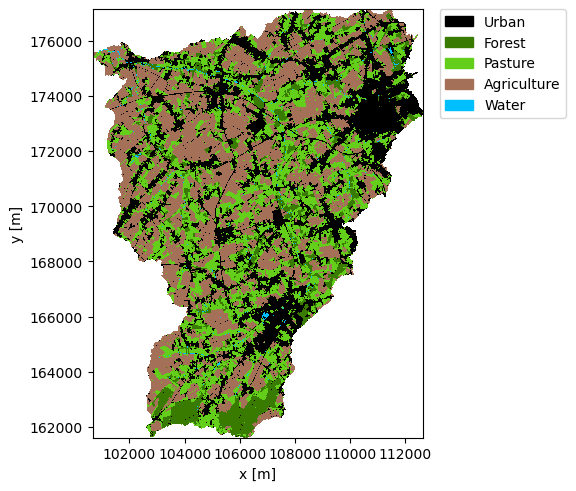

In [140]:
fig, ax = plt.subplots(constrained_layout = True)
fig, ax = plot_discrete_raster(fig, ax, landuse_zwalm.values, bounds = extent_31370, labels = labels, cmap = colormap)
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
if write_fig:
    fig.savefig('Figures/Figures_chapter_data/Landuse_zwalm.png', format = 'png')
    fig.savefig('Figures/Figures_chapter_data/Landuse_zwalm.pdf', format = 'pdf')
fig

In [87]:
unique_values = np.unique(landuse_zwalm.values)

In [88]:
unique_values = unique_values[~np.isnan(unique_values)]

In [89]:
unique_values

array([1., 2., 3., 4., 5.])

In [ ]:
unique